In [1]:
import torch

meta = torch.load('/home/isabella/opentensor/research/consensus/metagraph_consensus_scanner/netuid1_block3857360.pt')
# meta

## Helper functions

In [235]:
def get_SN(netuid): 
    meta_0 = list(metas[netuid].values())[0]
    validator_uids = meta_0.uids[meta_0.validator_trust > 0]
    miner_uids = meta_0.uids[meta_0.validator_trust > 0]
    validator_hotkeys = [meta_0.hotkeys[uid] for uid in validator_uids]
    weights = torch.load(f'./results/SN{netuid}_weights.pt')
    downtime = torch.load(f'./results/SN{netuid}_downtime.pt')
    return {
        'meta_0': meta_0,
        'validator_uids': validator_uids,
        'miner_uids': miner_uids,
        'validator_hotkeys': validator_hotkeys,
        'weights': weights,
        'downtime': downtime
    } 

## Reload metagraphs

In [151]:
import os
from typing import List
import numpy as np
from multiprocessing.pool import ThreadPool

class ExperimentSetup:
    def __init__(self,
        processes: int = 30, # processes to run with 
        tempo: int = 360, # the tempo on chain (blocks), how often are the chain calculating consensus.
        start_block: int = 3857000, # - 768 * 360, # (28 Sep) the block to refer to to start the experiment
        conceal_period: List = None, # the range of conceal period for experiment
        alpha_lows: List = None, # the range of alpha lows for experiment
        alpha_highs: List = None, # the range of alpha highs for experiment
        data_points: int = 256, # 1024, # number of datapoints to collect for experiment
        netuids: List = None,
        metagraph_storage_path = "./metagraph_consensus_scanner",
        result_path = "./results",
        liquid_alpha = False,
        consensus_precision = 0.0001,
    ):
        self.processes = processes
        self.tempo = tempo  
        self.start_block = start_block  
        self.data_points = data_points  
        self.metagraph_storage_path = metagraph_storage_path
        self.result_path = result_path
        self.liquid_alpha = liquid_alpha
        self.consensus_precision = consensus_precision

        if conceal_period == None:
            self.conceal_periods = [0] + list(range(1, 16, 2))  
        else:
            self.conceal_periods = conceal_period

        if netuids == None:
            self.netuids = range(1, 38)
        else:
            self.netuids = netuids

        self.alpha_highs = alpha_highs if alpha_highs else [round(a,2) for a in np.arange(0.1, 0.95, 0.2)]
        
        self.alpha_lows = alpha_lows if alpha_lows else [round(a,2) for a in np.arange(0.1, 0.95, 0.2)]
        
        self.create_directory()

    def create_directory(self):
        if not os.path.isdir(self.metagraph_storage_path):
            os.makedirs(self.metagraph_storage_path)

        if not os.path.isdir(self.result_path):
            os.makedirs(self.result_path)

def get_metagraphs(setup):
    def load_metagraph(file_name, netuid, block):
        try:
            meta = torch.load(file_name)
            return meta
        except Exception as E:
            print(E)
            return None

    metas = {}

    # === Collect metagraphs that has to be loaded ===
    args = []
    for netuid in setup.netuids:
        metas[netuid] = {}
        for data_point in range(setup.data_points):
            block = setup.start_block + setup.tempo * data_point
            file_name = f"{setup.metagraph_storage_path}/netuid{netuid}_block{block}.pt"
            args.append((file_name, netuid, block))

            for conceal_period in setup.conceal_periods:
                block = setup.start_block + setup.tempo * (
                    data_point + conceal_period
                )
                file_name = f"{setup.metagraph_storage_path}/netuid{netuid}_block{block}.pt"
                args.append((file_name, netuid, block))

    # === Load metagraphs with multiprocessing ===
    with ThreadPool() as pool:
        results = pool.starmap(load_metagraph, args)

    # === Sort out the metagraphs into a dict ===
    for meta, (file_name, netuid, block) in zip(results, args):
        if netuid not in metas:
            metas[netuid] = {}
        metas[netuid][block] = meta

    return metas

setup = ExperimentSetup(netuids = [19, 9, 1, 11, 4, 29, 18, 24, 2, 8, 13, 31])
metas = get_metagraphs(setup)

## Save aggregated weights

In [237]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from dtaidistance import dtw_ndim

for netuid in setup.netuids:
    meta_0 = list(metas[netuid].values())[0]
    validator_uids = meta_0.uids[meta_0.validator_trust > 0]
    miner_uids = meta_0.uids[meta_0.validator_trust > 0]
    validator_hotkeys = [meta_0.hotkeys[uid] for uid in validator_uids]

    weights = {}
    downtime = {}

    for hotkey in validator_hotkeys:
        weights[hotkey] = []
        downtime[hotkey] = []
        
    for block, meta in metas[netuid].items():
        for hotkey in validator_hotkeys:
            try:
                validator_uid = meta.hotkeys.index(hotkey)
                weights[hotkey].append(torch.tensor(meta.W[validator_uid]))
                
                if len(weights[hotkey]) >= 3 and torch.all(weights[hotkey][-3] == weights[hotkey][-1]):
                    downtime[hotkey].append(True)
                else:
                    downtime[hotkey].append(False)
            except:
                weights[hotkey].append(torch.zeros(meta.W.shape[1]))
                downtime[hotkey].append(True)

    for hotkey in validator_hotkeys:
        weights[hotkey] = torch.stack(weights[hotkey]) # [n_timesteps, n_values]

    torch.save(weights, f'./results/SN{netuid}_weights.pt')
    torch.save(downtime, f'./results/SN{netuid}_downtime.pt')

## Calculate dtw distance 

In [204]:
import plotly.express as px
import pandas as pd
import networkx as nx

netuid = 19

meta_0 = list(metas[netuid].values())[0]
validator_uids = meta_0.uids[meta_0.validator_trust > 0]
miner_uids = meta_0.uids[meta_0.validator_trust > 0]
validator_hotkeys = [meta_0.hotkeys[uid] for uid in validator_uids]

weights = torch.load(f'./results/SN{netuid}_weights.pt')

# calculate matrix distance using DTW 
w = list(weights.values())
distance = []
for i in range(len(w)):
    d = torch.zeros(len(w))
    w_i = w[i][-20:]
    for j in range(i + 1):
        w_j = w[j][-20:]
        d[j] = dtw_ndim.distance(np.array(w_i), np.array(w_j))
    distance.append(d)
distance = torch.stack(distance)
torch.save(distance, f'./results/SN{netuid}_dtw.pt')

distance = torch.load(f'./results/SN{netuid}_dtw.pt')

In [205]:
from sklearn.cluster import AgglomerativeClustering

X = np.array(distance + distance.tril().T)
clustering = AgglomerativeClustering().fit(X)
(clustering.labels_ == 0).nonzero()


/home/isabella/.local/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:796: ClusterWarning:

The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



(array([ 0,  5,  8, 11, 18]),)

In [206]:

G = nx.from_numpy_matrix(np.array(distance + distance.tril().T)) 
pos = nx.random_layout(G) 

df = pd.DataFrame(torch.tensor(np.stack(list(pos.values()))), columns = ['x', 'y'])
df['uid'] = validator_uids
px.scatter(df, x = 'x', y = 'y', hover_data='uid', width = 600, height = 600, title = 'SN 19, dtw')

## Classification with transformer

In [4]:
from huggingface_hub import hf_hub_download
import torch
from transformers import TimeSeriesTransformerModel

train-batch.pt:   0%|          | 0.00/90.0k [00:00<?, ?B/s]

In [123]:
batch = {
    'past_values': [],
    'past_time_features': [],
    'future_values': [],
    'future_time_features': [],
}

idx_to_hk = {}

for i, (hk, w) in enumerate(weights.items()):
    sequence_len = 32
    input_size = 271

    past_values = w.reshape(-1, sequence_len, input_size)
    
    batch_size = past_values.shape[0]

    batch['past_values'].append(past_values)

    past_time_features = torch.tensor(range(256)).reshape(-1, sequence_len, 1)
    batch['past_time_features'].append(past_time_features)
    
    batch['future_values'].append(torch.ones(batch_size, 1, input_size) * i)
    batch['future_time_features'].append(torch.zeros(batch_size, 1, 1) )
    

    idx_to_hk[i] = hk

for k, v in batch.items():
    batch[k] = torch.cat(v)
    print(k, batch[k].shape)

model = TimeSeriesTransformerForPrediction(
    TimeSeriesTransformerConfig(
        prediction_length = 1,
        context_length = 25,
        input_size = 271,
        feature_size = 2440
    )
)

past_values torch.Size([184, 32, 271])
past_time_features torch.Size([184, 32, 1])
future_values torch.Size([184, 1, 271])
future_time_features torch.Size([184, 1, 1])


In [132]:
from huggingface_hub import hf_hub_download
import torch
from transformers import TimeSeriesTransformerForPrediction

outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=torch.ones_like(batch["past_values"]),
    future_values=batch["future_values"],
    future_time_features=batch['future_time_features']
)

loss = outputs.loss
loss.backward()

# during inference, one only provides past values
# as well as possible additional features
# the model autoregressively generates future values
outputs = model.generate(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    future_time_features=batch['future_time_features']
)

mean_prediction = outputs.sequences.mean(dim=1)

## TS visualization

<Figure size 640x480 with 0 Axes>

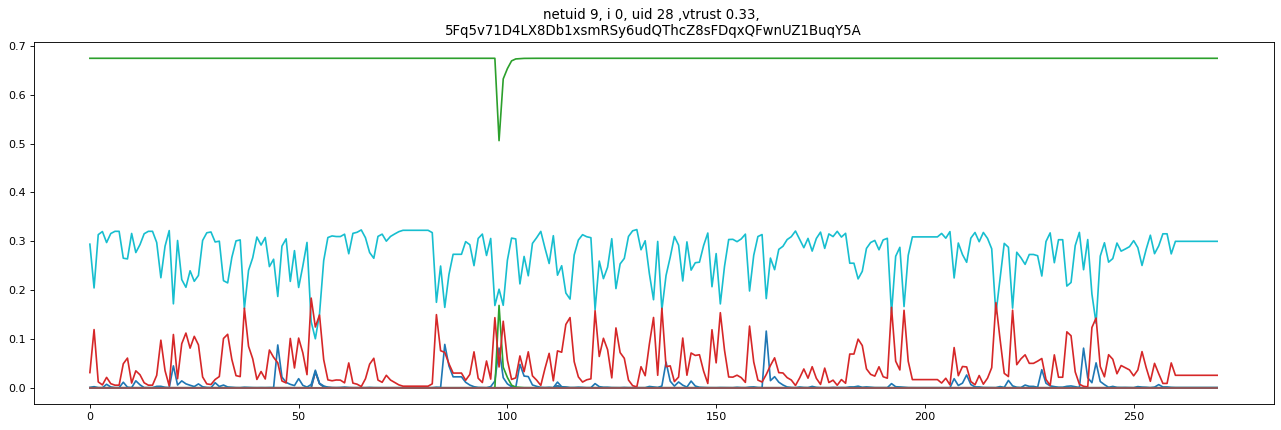

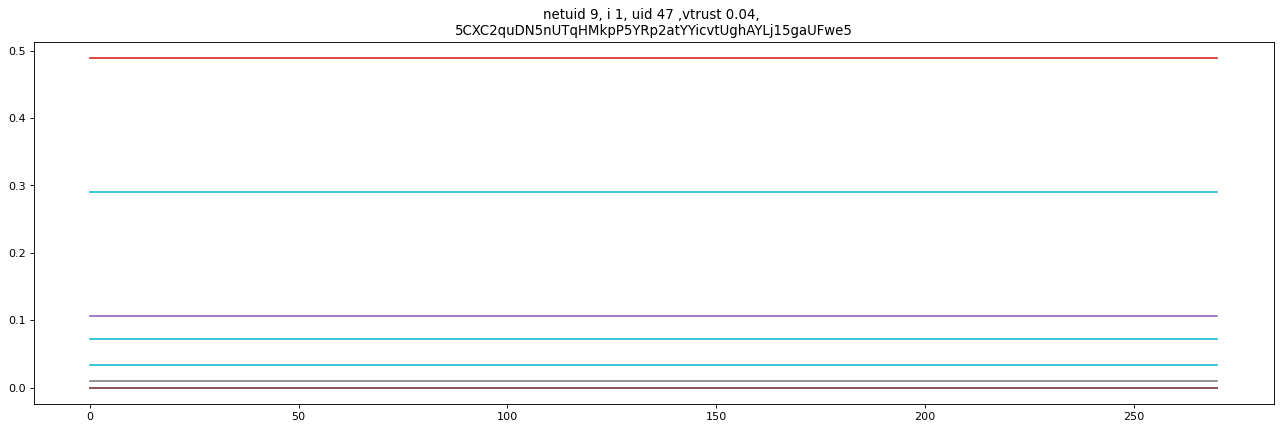

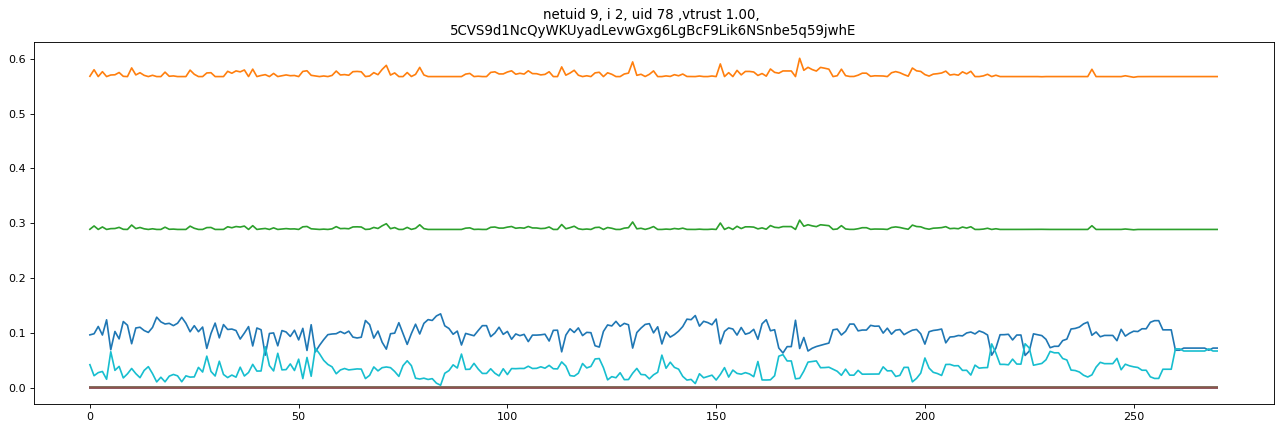

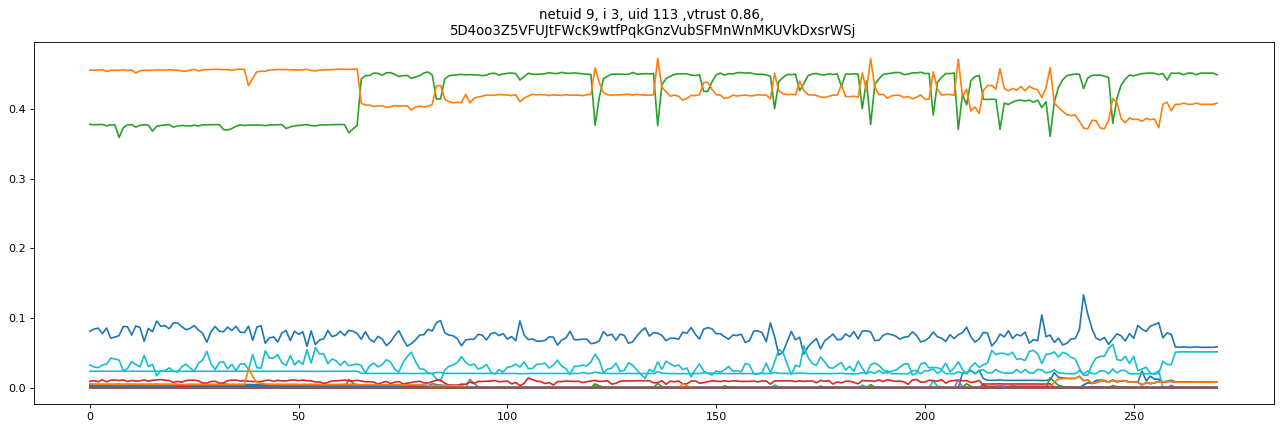

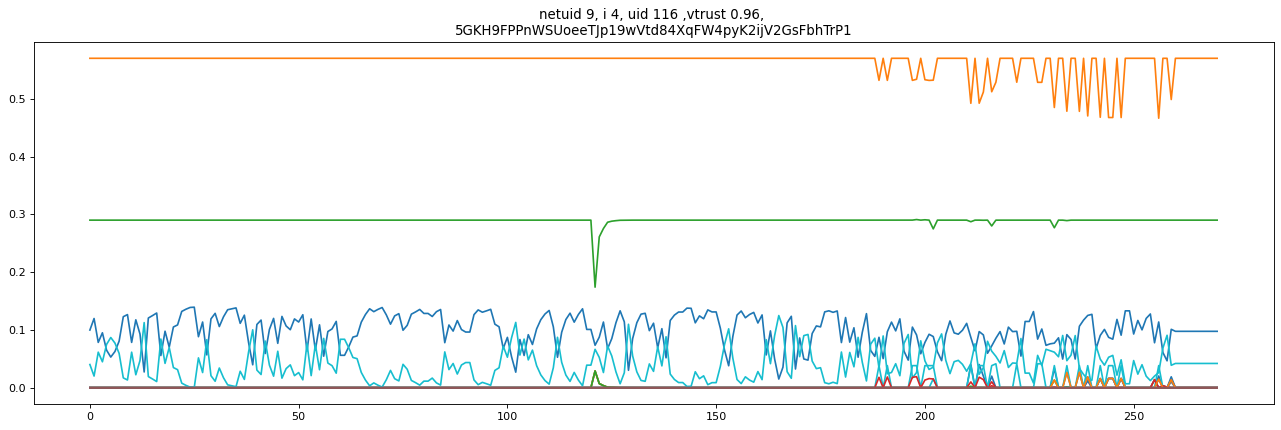

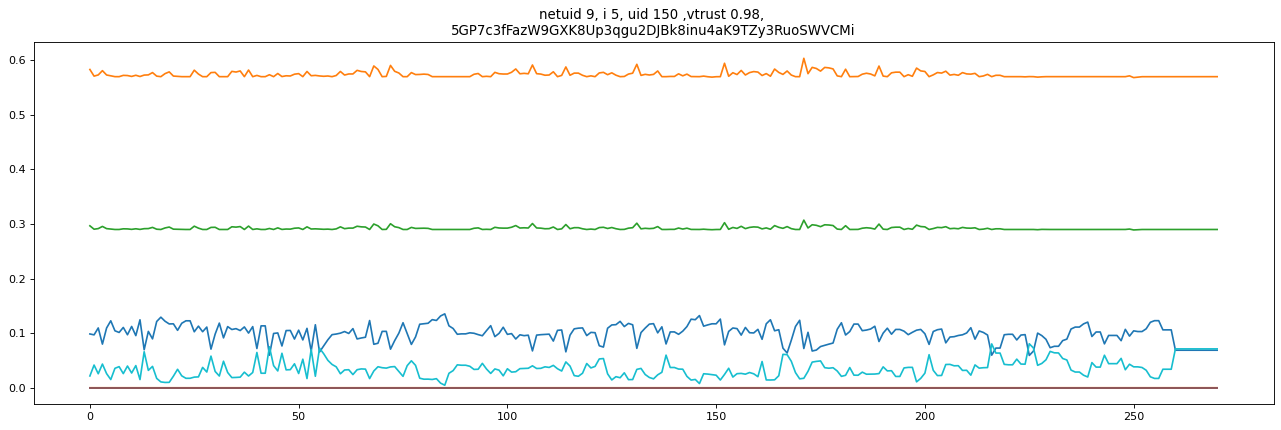

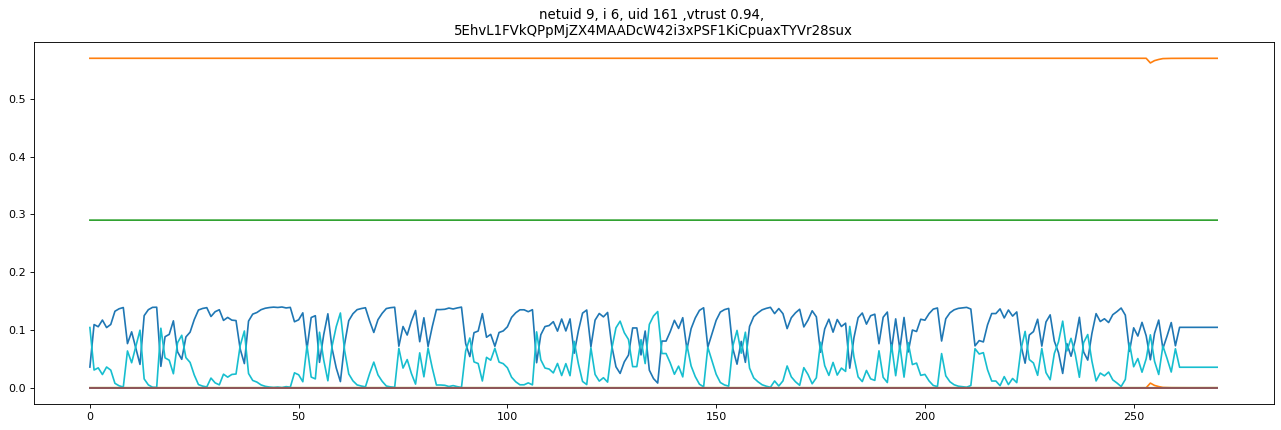

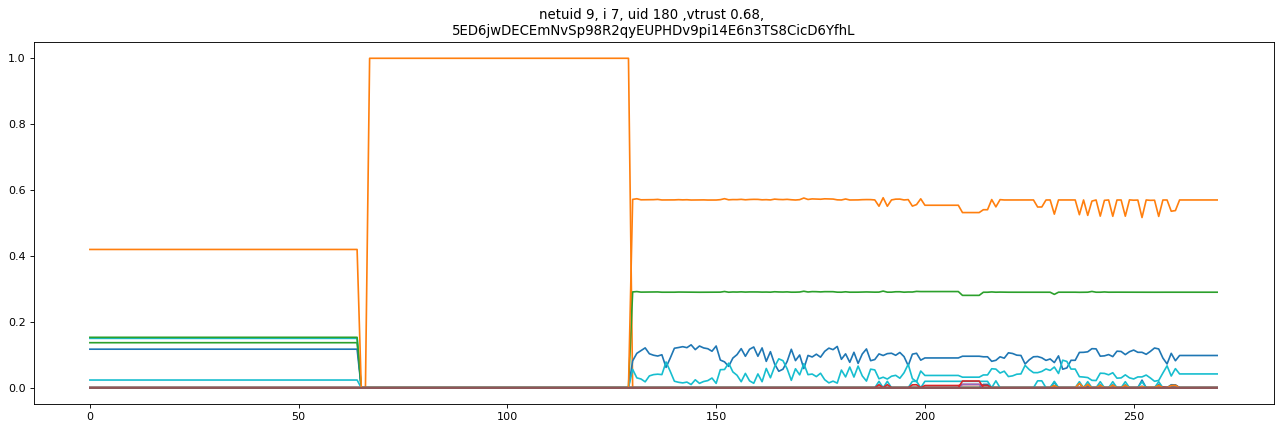

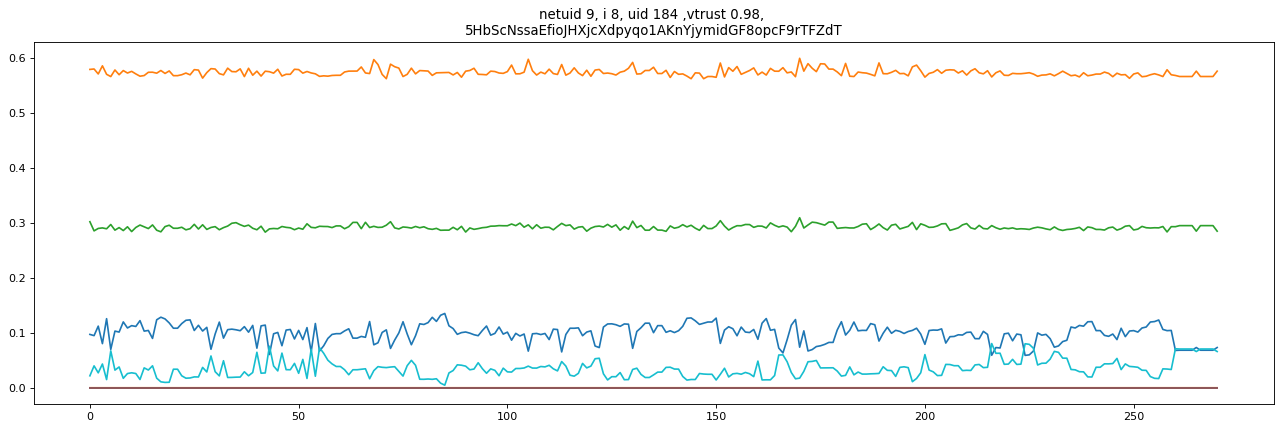

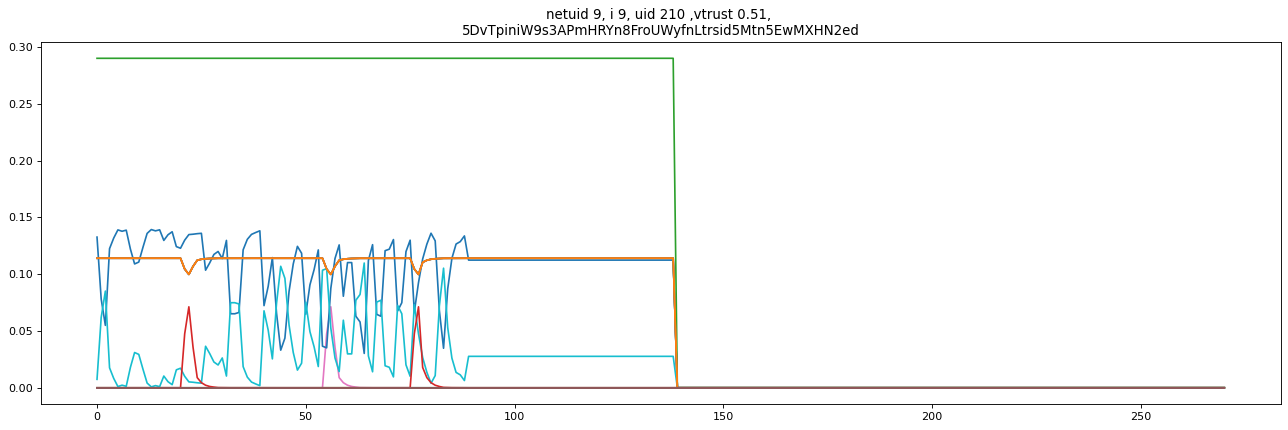

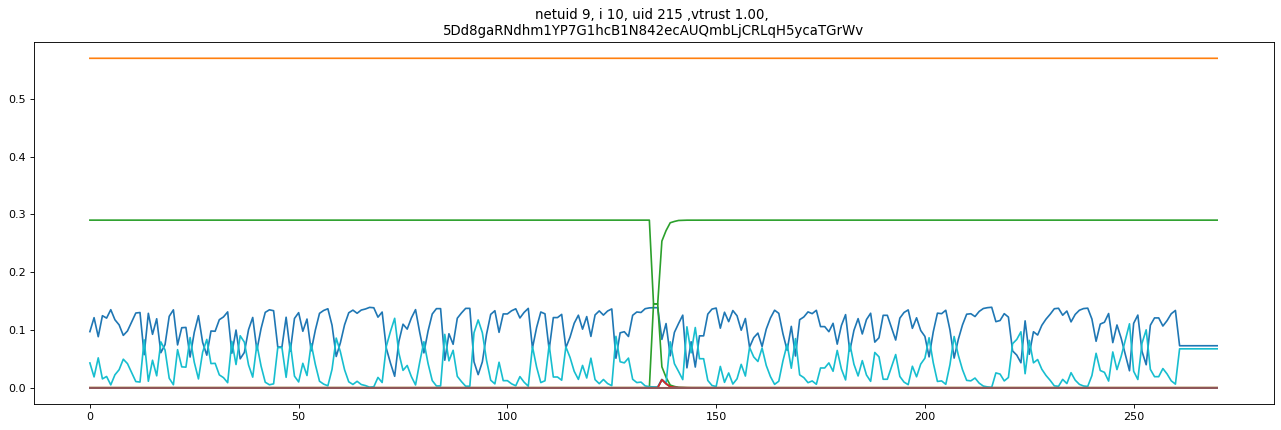

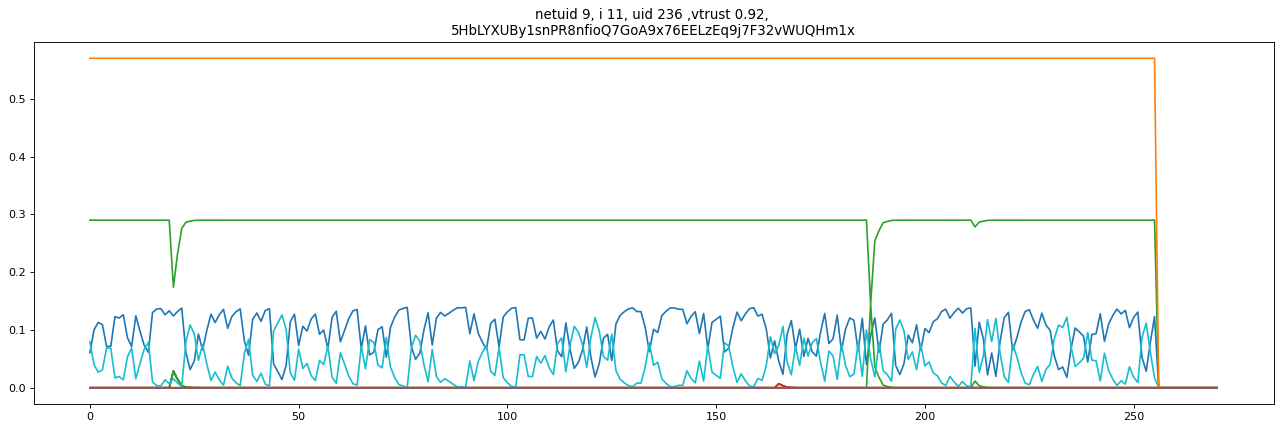

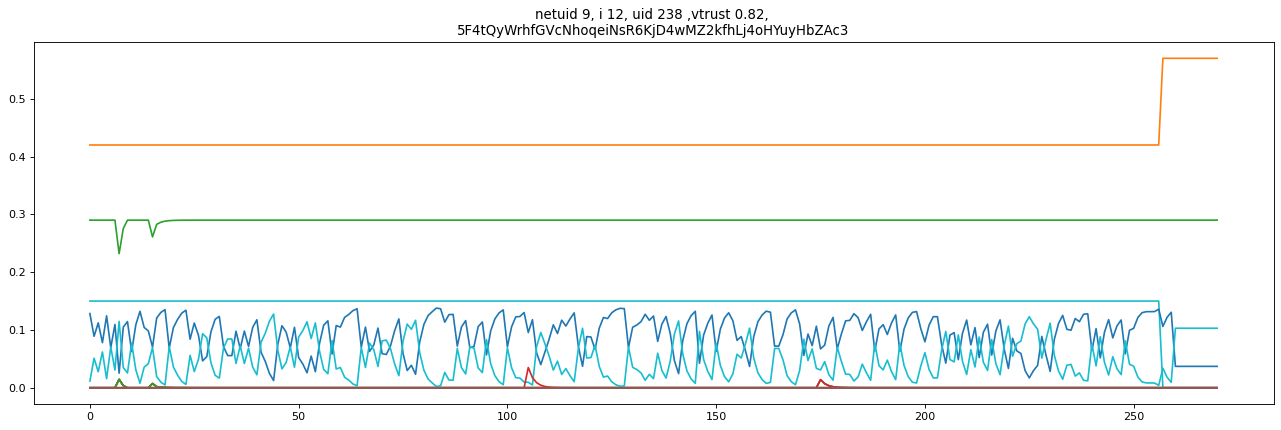

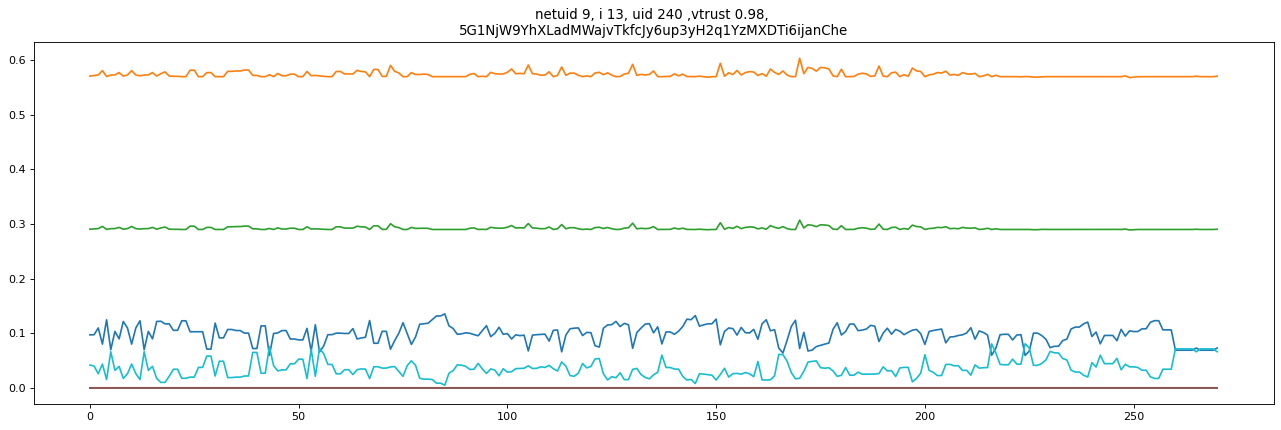

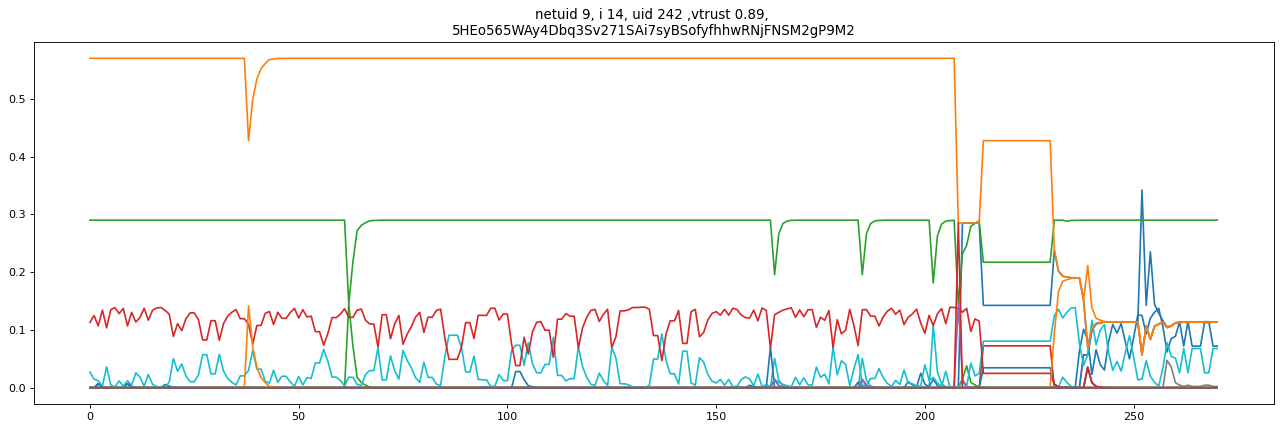

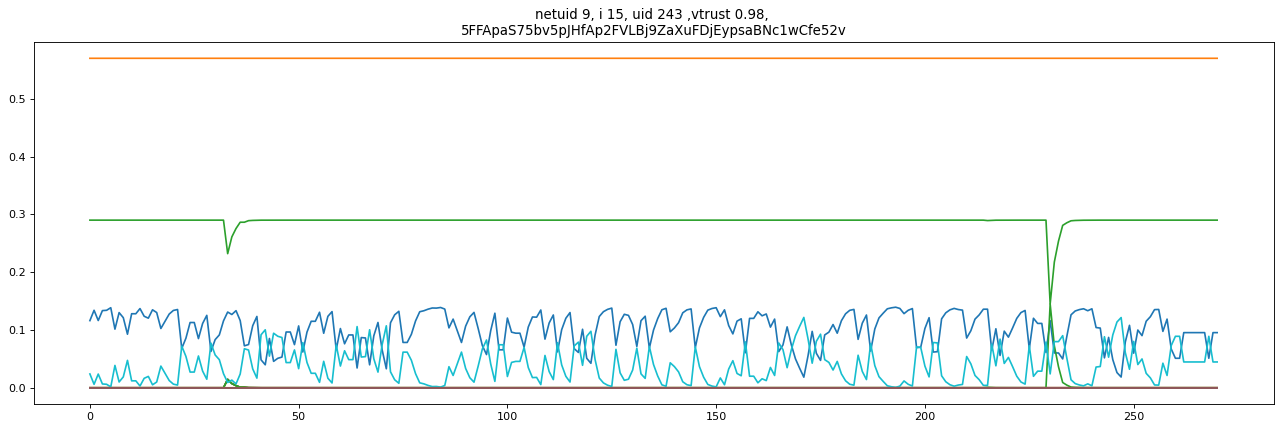

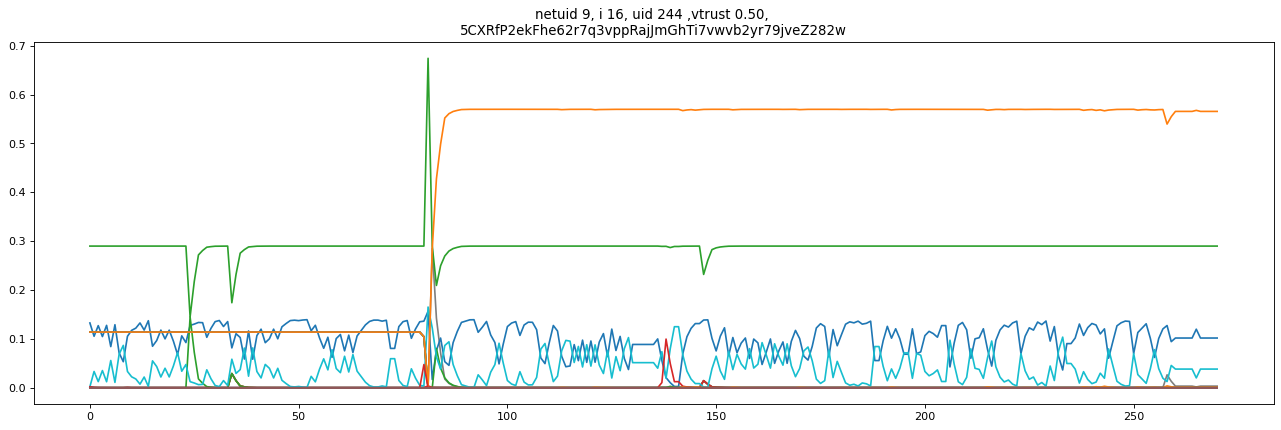

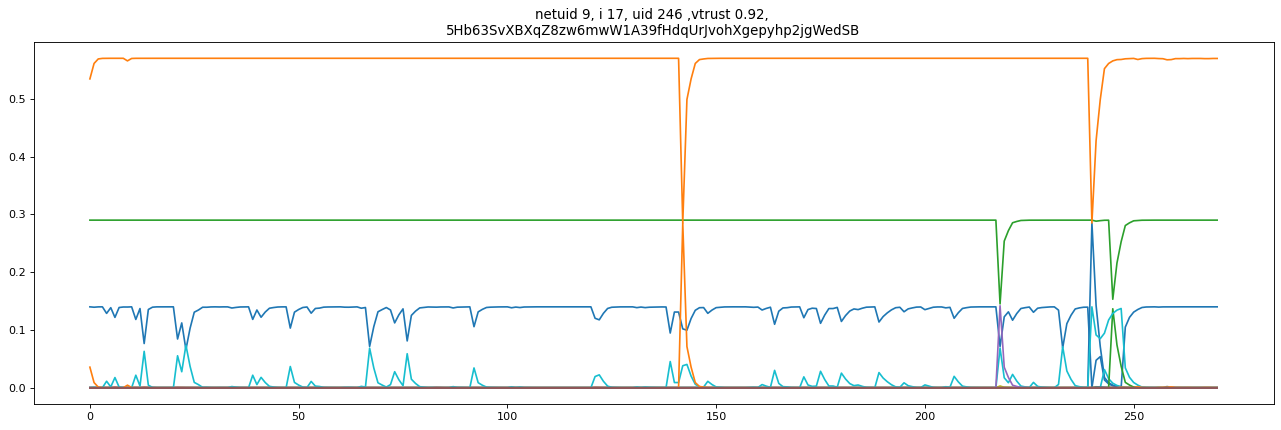

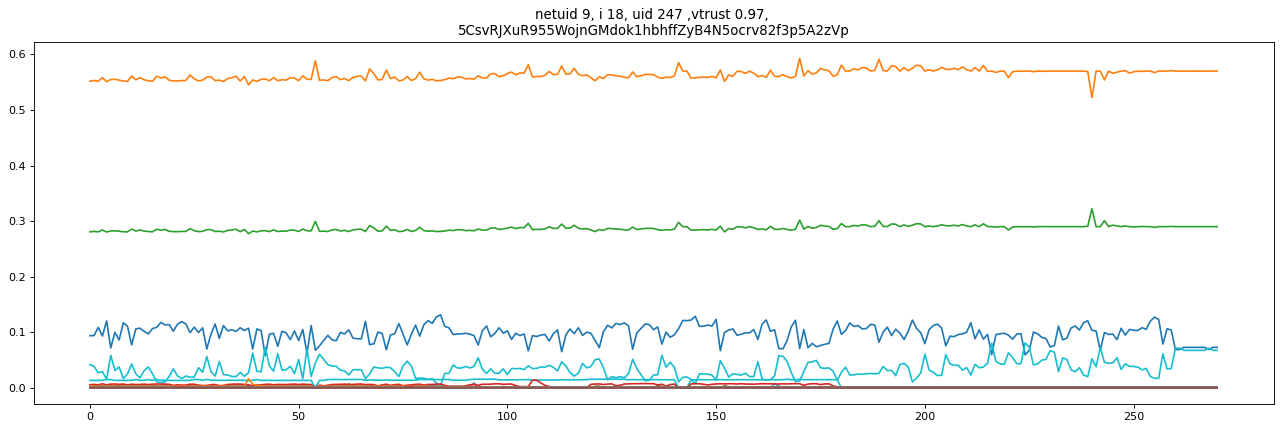

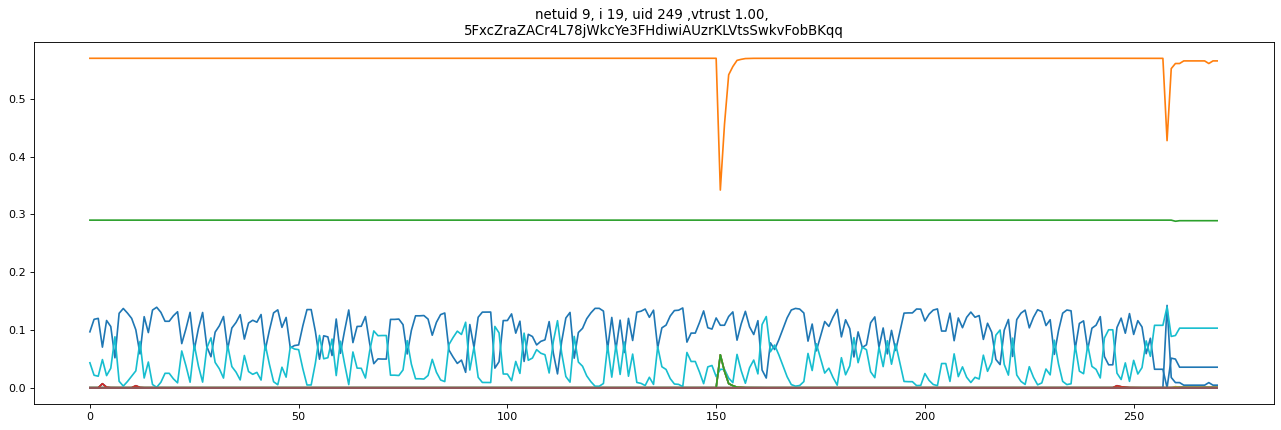

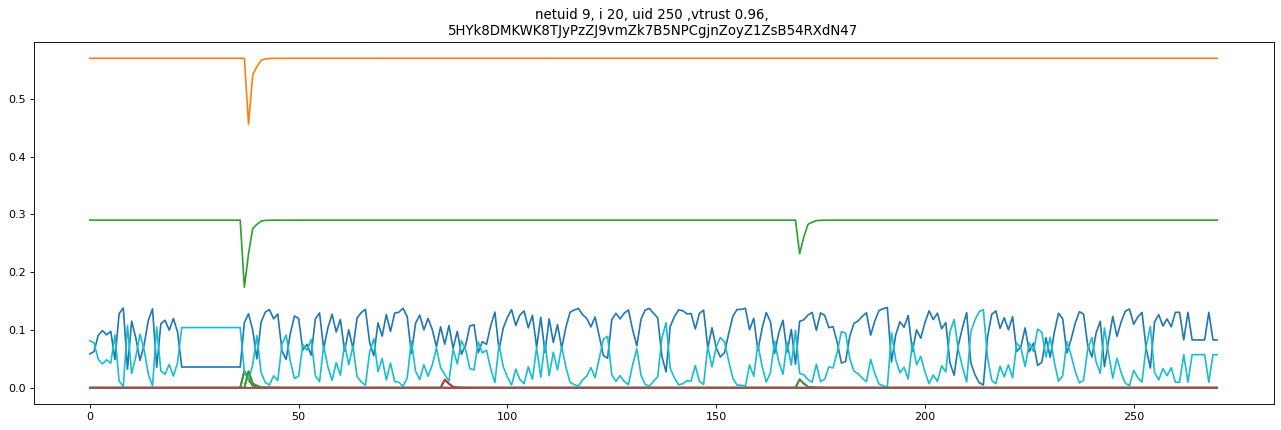

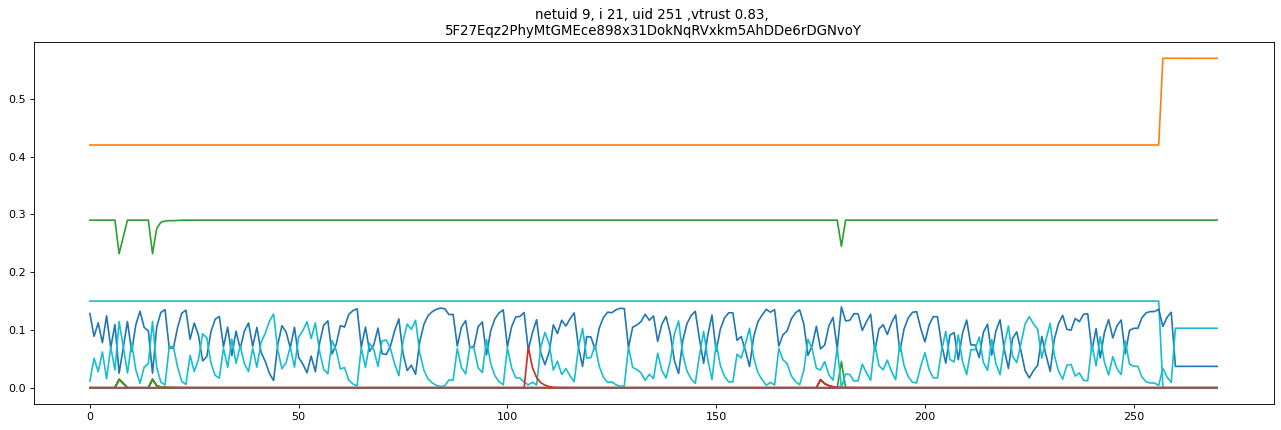

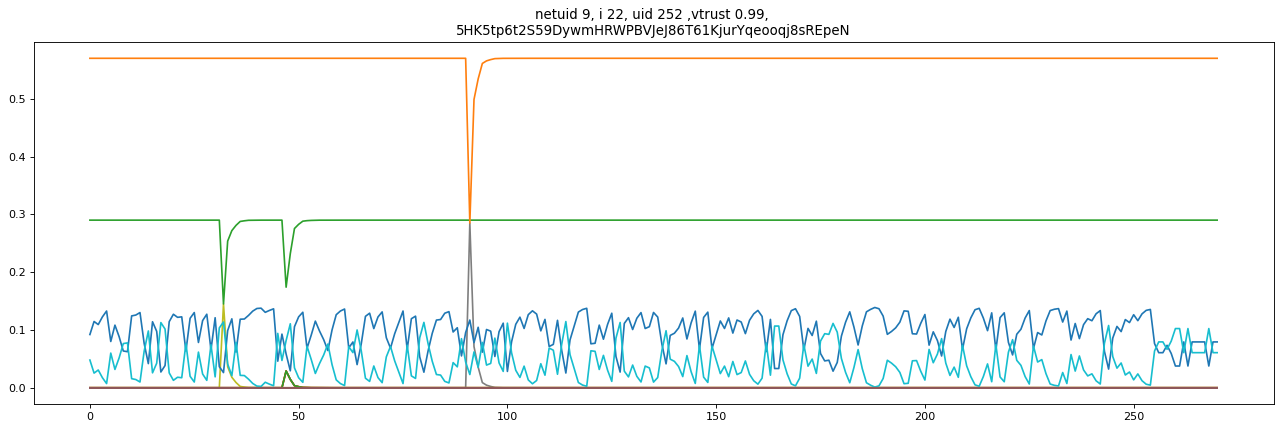

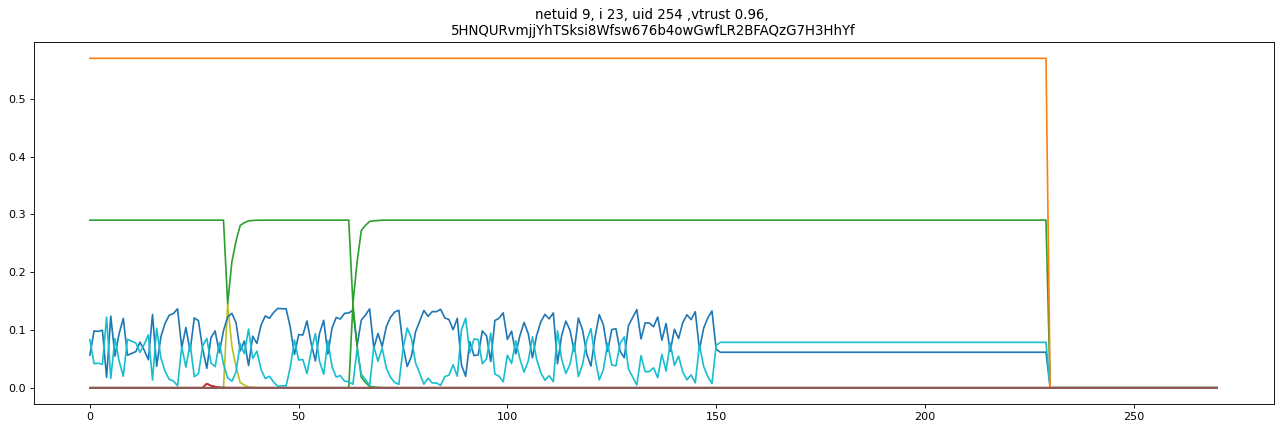

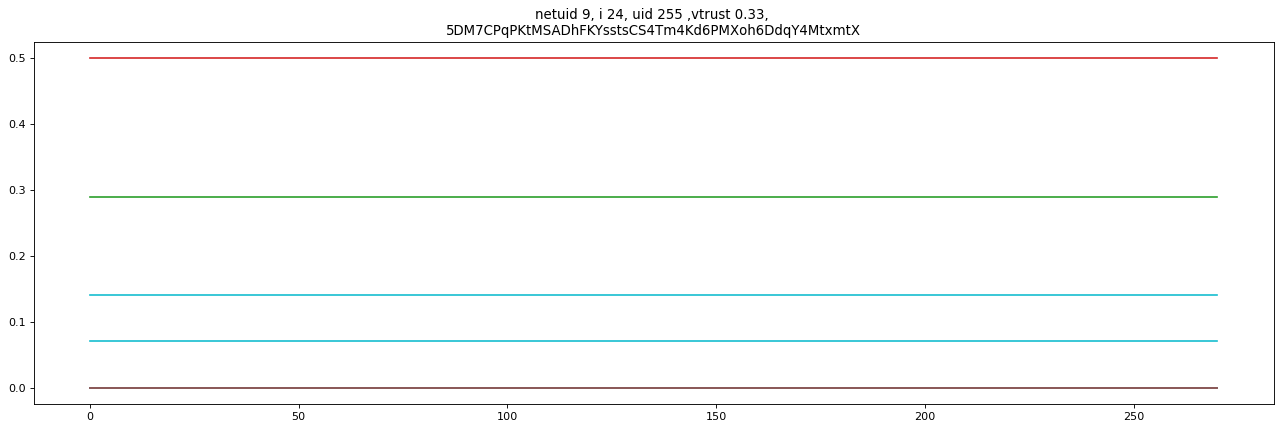

In [312]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt 
figure(figsize=(8, 6), dpi=80)

netuid = 9# next(netuids)
SN_info = get_SN(netuid)

meta_0 = SN_info['meta_0']
validator_uids = SN_info['validator_uids']
miner_uids = SN_info['miner_uids']
validator_hotkeys = SN_info['validator_hotkeys']
weights = SN_info['weights']
downtime = SN_info['downtime']

# plots 
for i, hotkey in enumerate(validator_hotkeys):
    figure(figsize=(20, 6), dpi=80)
    plt.plot(weights[hotkey])
    plt.title(f"netuid {netuid}, i {i}, uid {meta_0.hotkeys.index(hotkey)} ,vtrust {meta_0.validator_trust[meta_0.hotkeys.index(hotkey)]:.2f}, \n{hotkey}")
    plt.show()

## Classify with shapelet 

In [268]:
import pickle

def get_batch(netuid):
    SN_info = get_SN(netuid)

    idx_to_hk = {}

    batch = {
        'past_values': [],
        'future_values': [],
    }

    weights = SN_info['weights']

    for i, (hk, w) in enumerate(weights.items()):
        sequence_len = 271
        input_size = w.shape[1]
        # past_values = w.reshape(-1, sequence_len, input_size)
        # past_values = torch.transpose(past_values, 1, 2).flatten(0, 1)
        past_values = w.T
        batch_size = past_values.shape[0]
        batch['past_values'].append(past_values)
        batch['future_values'].append(torch.ones(batch_size) * i)

    for k, v in batch.items():
        batch[k] = torch.cat(v)
        print(netuid, k, batch[k].shape)

    return batch

def train_shapeley(netuid, batch):
    X = batch['past_values']
    y = batch['future_values']
    clf = LearningShapelets(random_state=42, tol=0.01, n_jobs = 30)
    clf.fit(X, y)

    # save
    with open(f'./results/SN{netuid}_shapelet_model.pkl','wb') as f:
        pickle.dump(clf, f)

for netuid in setup.netuids:
    if netuid == 1:
        continue
    batch = get_batch(netuid)
    train_shapeley(netuid, batch)    

In [247]:
import matplotlib.pyplot as plt
import numpy as np
from pyts.classification import LearningShapelets
from pyts.datasets import load_gunpoint
from pyts.utils import windowed_view

In [293]:
import pickle
import matplotlib.pyplot as plt

In [311]:
netuid = 13
for netuid in setup.netuids:
    if netuid == 1:
        continue
    
    print("\n========================\n")
    with open(f'./results/SN{netuid}_shapelet_model.pkl', 'rb') as f:
        clf = pickle.load(f)

    batch = get_batch(netuid)
    X = batch['past_values']
    y = batch['future_values']

    for c in batch['future_values'].unique():
        s = clf.score(X[y == c], y[y == c])
        if s > 0:
            print(f"c {c}, score {s}, {len(y[y == c])}")

    prob = clf.predict_proba(X)
    print(prob[prob > 0.05])



19 past_values torch.Size([5888, 271])
19 future_values torch.Size([5888])
c 20.0, score 1.0, 256
[]


9 past_values torch.Size([6400, 271])
9 future_values torch.Size([6400])
c 15.0, score 0.984375, 256
c 20.0, score 0.01171875, 256
[]


11 past_values torch.Size([5888, 271])
11 future_values torch.Size([5888])
c 20.0, score 1.0, 256
[]


4 past_values torch.Size([6400, 271])
4 future_values torch.Size([6400])
c 12.0, score 1.0, 256
[]


29 past_values torch.Size([6400, 271])
29 future_values torch.Size([6400])
c 17.0, score 1.0, 256
[]


18 past_values torch.Size([7168, 271])
18 future_values torch.Size([7168])
c 8.0, score 1.0, 256
[]


24 past_values torch.Size([5376, 271])
24 future_values torch.Size([5376])
c 11.0, score 1.0, 256
c 17.0, score 0.00390625, 256
[]


2 past_values torch.Size([5888, 271])
2 future_values torch.Size([5888])
c 20.0, score 1.0, 256
[]


8 past_values torch.Size([6656, 271])
8 future_values torch.Size([6656])
c 2.0, score 0.98828125, 256
c 20.0, score 

array([], dtype=float64)

In [297]:
np.quantile(corr, 0.5)

0.0029621401074742624

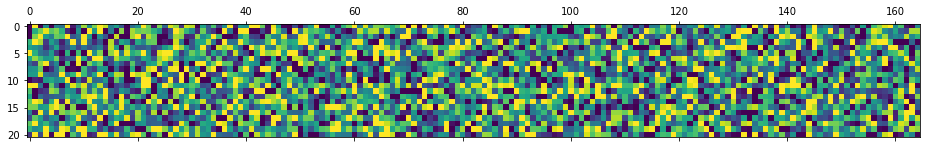

In [298]:
plt.matshow(clf.coef_, vmin = -0.012, vmax = 0.012)
plt.show()

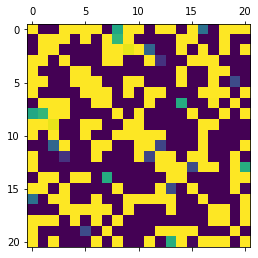

In [299]:
corr = np.corrcoef(clf.coef_)
plt.matshow(corr, vmin = -0.01, vmax = 0.01)
plt.show()

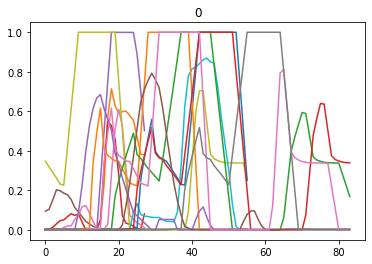

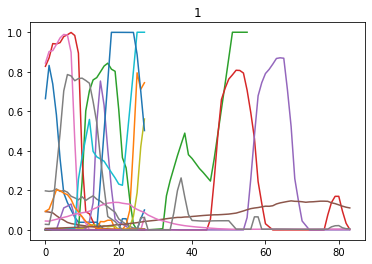

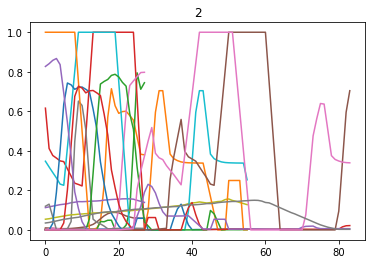

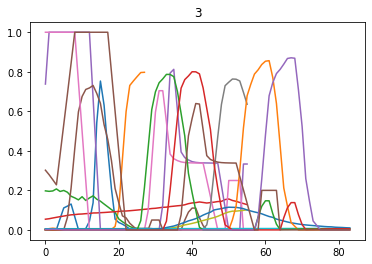

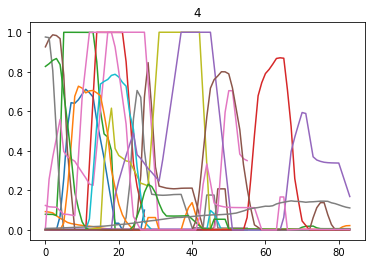

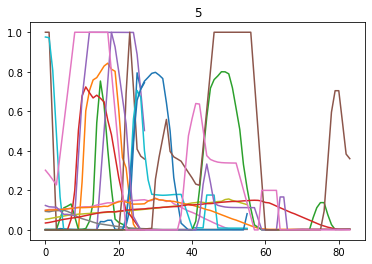

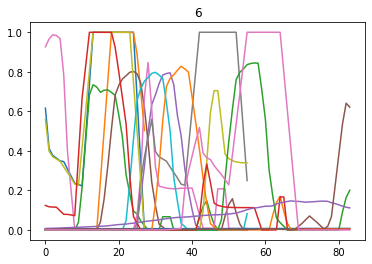

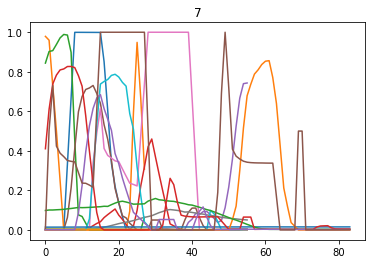

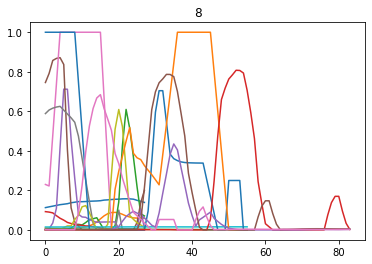

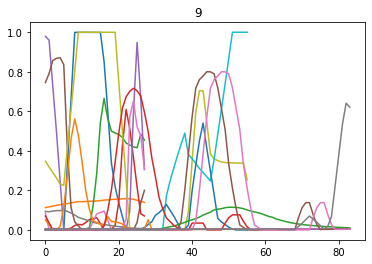

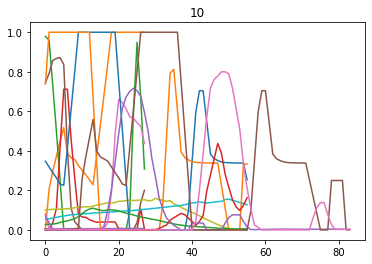

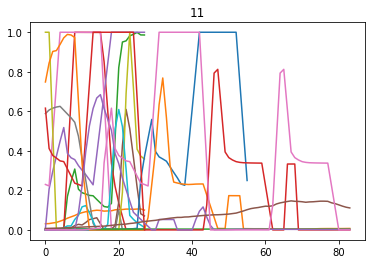

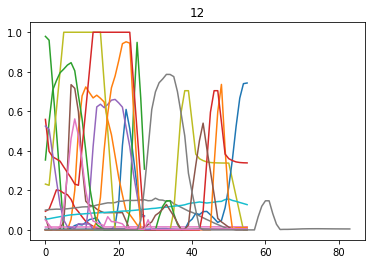

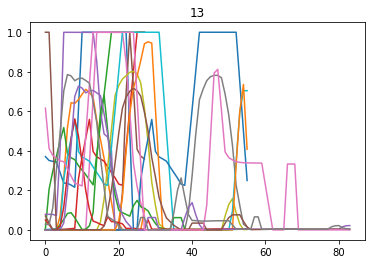

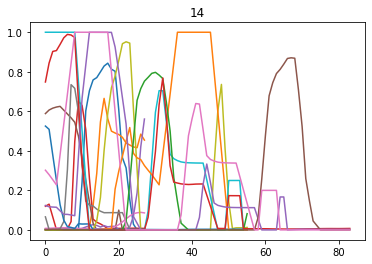

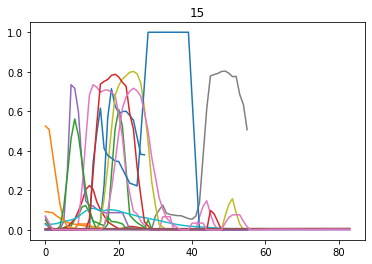

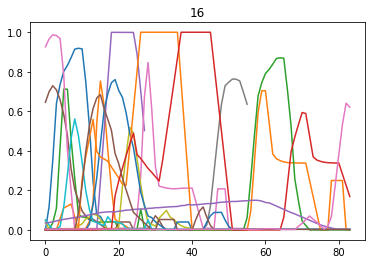

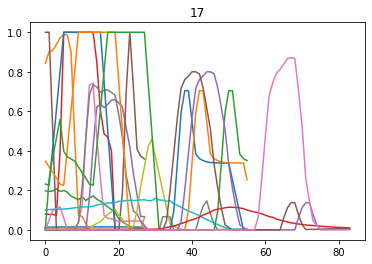

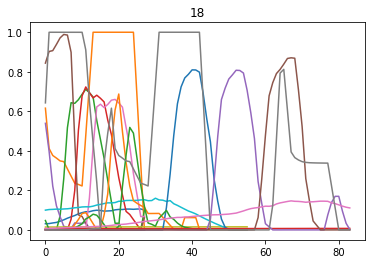

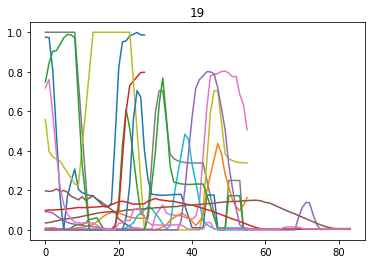

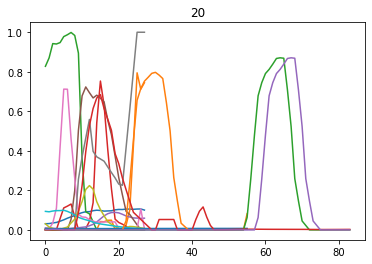

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│    1 for c in range(23):                                                                         │
│ ❱  2 │   low_q = np.quantile( clf.coef_[c], 0.05)                                                │
│    3 │   high_q = np.quantile( clf.coef_[c], 0.95)                                               │
│    4 │                                                                                           │
│    5 │   for i in range(156):                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: index 21 is out of bounds for axis 0 with size 21

In [300]:
for c in range(23): 
    low_q = np.quantile( clf.coef_[c], 0.05)
    high_q = np.quantile( clf.coef_[c], 0.95)

    for i in range(156):
        if clf.coef_[c, i] > high_q or clf.coef_[c, i] < low_q:
            plt.plot(np.asarray(clf.shapelets_[0, i]))
    plt.title(c)
    plt.show()

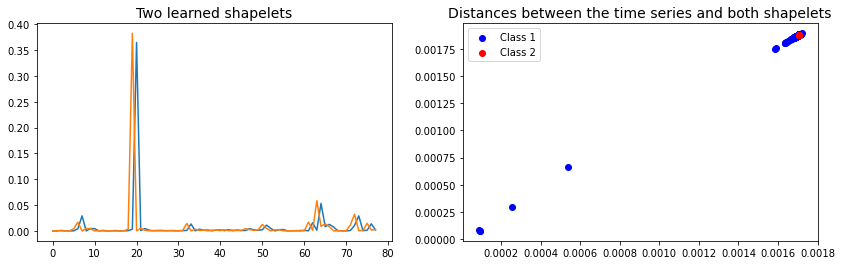

In [ ]:

# Select two shapelets
shapelets = np.asarray([clf.shapelets_[0, -9], clf.shapelets_[0, -12]])

# Derive the distances between the time series and the shapelets
shapelet_size = shapelets.shape[1]
X_window = windowed_view(X, window_size=shapelet_size, window_step=1)
X_dist = np.mean(
    (X_window[:, :, None] - shapelets[None, :]) ** 2, axis=3).min(axis=1)

plt.figure(figsize=(14, 4))

# Plot the two shapelets
plt.subplot(1, 2, 1)
plt.plot(shapelets[0])
plt.plot(shapelets[1])
plt.title('Two learned shapelets', fontsize=14)

# Plot the distances
plt.subplot(1, 2, 2)
for color, label in zip('br', (1, 2)):
    plt.scatter(X_dist[y == label, 0], X_dist[y == label, 1],
                c=color, label='Class {}'.format(label))
plt.title('Distances between the time series and both shapelets',
          fontsize=14)
plt.legend()
plt.show()

## Downtime analysis

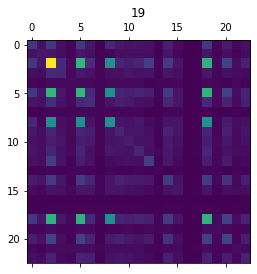

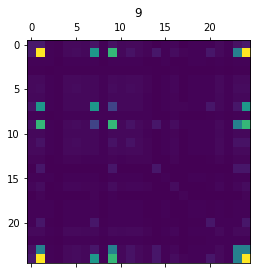

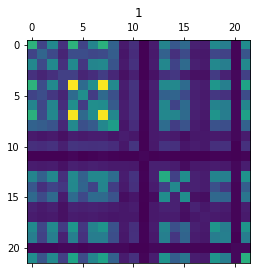

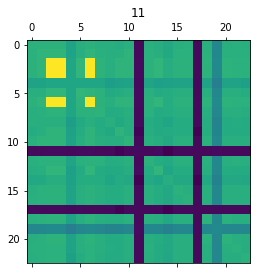

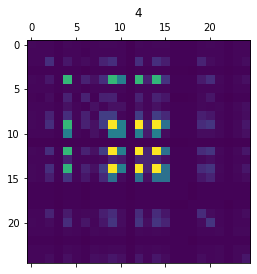

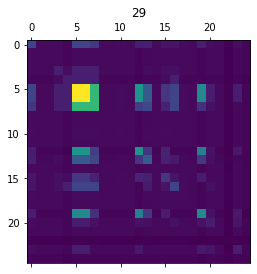

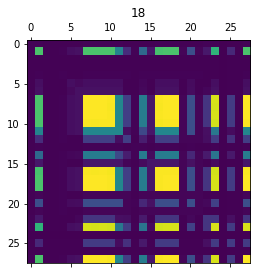

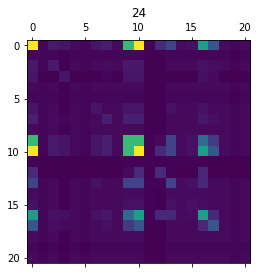

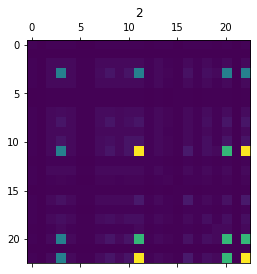

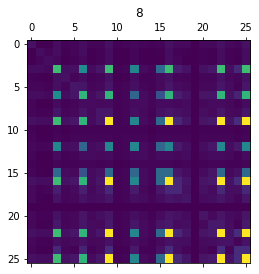

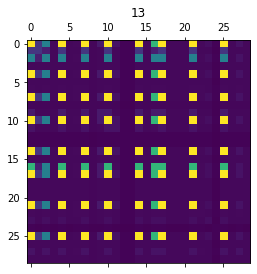

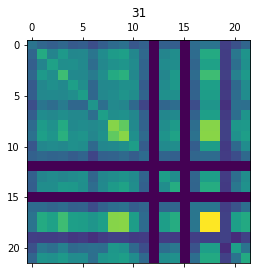

In [336]:
# netuid = 13
for netuid in setup.netuids:
    SN_info = get_SN(netuid)
    distance = []
    for hk, d1 in SN_info['downtime'].items():
        d = []
        for hk, d2 in SN_info['downtime'].items():
            d.append(torch.tensor(d1).long().dot(torch.tensor(d2).long()) / 271)

        d = torch.stack(d)
        distance.append(d)

    distance = torch.stack(distance)

    plt.matshow(distance)
    plt.title(f"{netuid}")
    plt.show()